In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import log_loss, accuracy_score
import csv
from sklearn.neural_network import MLPClassifier
import cv2
import mediapipe as mp
import pandas as pd
import time
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

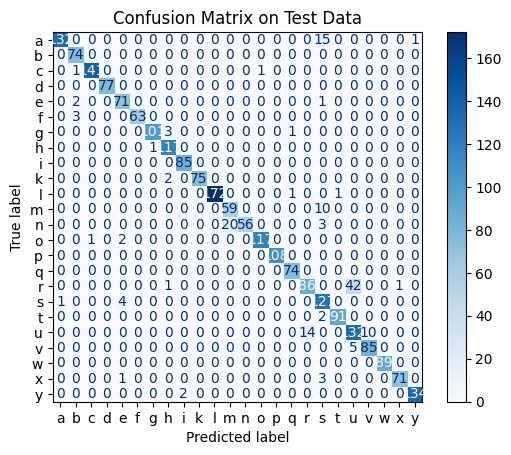

2025-08-02 20:41:36.707 python3.10[90307:115475084] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1754188898.032444 115475084 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1754188898.050657 115481368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754188898.058183 115481368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754188898.826947 115481366 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


a
b
c
d
e
g
g
Final sentence: abcdegg


In [4]:
# detect some hands 
class handDetector():
    def __init__(self):
        self.hands = mp.solutions.hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

    def get_landmarks(self, img):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.hands.process(img_rgb)

        if not results.multi_hand_landmarks:
            return None

        landmarks = results.multi_hand_landmarks[0]
        h, w, _ = img.shape
        return np.array([[int(pt.x * w), int(pt.y * h)] for pt in landmarks.landmark])

# machine learn
data = pd.read_csv('/Users/briarainscough/Desktop/hand_signals.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

X = data.drop('letter', axis=1)
y = data['letter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MLPClassifier(hidden_layer_sizes=(256, 64), max_iter=500, random_state=42)
model.fit(X_train, y_train)

# evaluate on test set
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Data")
plt.show()

# define main function
def main():
    cap = cv2.VideoCapture(0)
    #cap = cv2.VideoCapture('/Users/briarainscough/Desktop/hello_world.MOV')
    detector = handDetector()
    last_letter = ''
    repeat_count = 0
    current_sentence = "" 
    last_seen_time = time.time()
    hand_visible = False

    while True:
        ret, img = cap.read()
        
        if not ret:
            print("Failed to grab frame, ending...")
            break
        
        img = cv2.flip(img, 1)
        #img = cv2.flip(img, 0)
        key = cv2.waitKey(1) & 0xFF

        landmarks = detector.get_landmarks(img)

        current_time = time.time()

        if landmarks is not None and len(landmarks) == 21:
            flat_coords = landmarks.flatten().reshape(1, -1)
            flat_coords_df = pd.DataFrame(flat_coords, columns=X.columns) 
            probs = model.predict_proba(flat_coords_df)
            max_prob = np.max(probs)
        
            if max_prob > 0.75:
                predicted = model.predict(flat_coords_df)[0]

                if predicted == last_letter:
                    repeat_count += 1
                else:
                    last_letter = predicted
                    repeat_count = 1

                if repeat_count == 20:
                    print(predicted)
                    current_sentence += predicted
                    repeat_count = 0

                cv2.putText(img, predicted, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)

            last_seen_time = current_time
            hand_visible = True
            
        else:
            if hand_visible and (current_time - last_seen_time) > 1.0:
                # Hand disappeared for over 1s → insert space
                if not current_sentence.endswith(' '):
                    current_sentence += ' '
                    print("Added space")
                hand_visible = False

        # show sentence ON SCREEN 
        cv2.putText(img, current_sentence.strip(), (10, 130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        cv2.imshow("Hand Sign", img)

        if key == ord('q'):
            print("Final sentence:", current_sentence.strip())
            break

    cap.release()
    cv2.destroyAllWindows()

# run
if __name__ == '__main__':
    main()

In [5]:
# Make predictions
y_pred = model.predict(X_test)

# Print basic classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Full classification report (optional but helpful)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.937800963081862
Precision (macro): 0.9458328560783755
Recall (macro): 0.9404799705910903
F1 Score (macro): 0.9405995249906888

Classification Report:
              precision    recall  f1-score   support

           a       0.99      0.89      0.94       148
           b       0.93      1.00      0.96        74
           c       0.99      0.99      0.99       143
           d       1.00      1.00      1.00        77
           e       0.91      0.96      0.93        74
           f       1.00      0.95      0.98        66
           g       0.99      0.96      0.98       105
           h       0.95      0.99      0.97       118
           i       0.98      1.00      0.99        85
           k       1.00      0.97      0.99        77
           l       1.00      0.99      0.99       174
           m       0.75      0.86      0.80        69
           n       1.00      0.71      0.83        79
           o       0.99      0.97      0.98       120
           p       1.00    